In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 70 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':70}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from time import time
import timeit #imports timeit module
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv('./RiverRoad_Quan_RF.csv')

In [3]:
def LDA(X, y, gridid):
    fig, ax = plt.subplots()

    start_time = timeit.default_timer()

    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    acc_score = [];
    Truth = [];
    Output = [];
    GRID_ID = pd.DataFrame(columns=['GRID_ID'])

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        train_grid = gridid.iloc[train_index]
        test_grid= gridid.iloc[test_index]

        model = LinearDiscriminantAnalysis()

        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)

        viz = plot_roc_curve(model, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        GRID_ID = pd.merge(GRID_ID, test_grid, on='GRID_ID', how='outer')
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        Output.extend(pred_values);

    elapsed = timeit.default_timer() - start_time

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC for LDA")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

    output_df = pd.concat([GRID_ID, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    return output_df, elapsed, confusion_matrix(Truth, Output), classification_report(Truth, Output, digits=4), acc_score, plt

In [4]:
def QDA(X, y, gridid):
    fig, ax = plt.subplots()

    start_time = timeit.default_timer()

    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    acc_score = [];
    Truth = [];
    Output = [];
    GRID_ID = pd.DataFrame(columns=['GRID_ID'])

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        train_grid = gridid.iloc[train_index]
        test_grid= gridid.iloc[test_index]

        model = QuadraticDiscriminantAnalysis()

        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)

        viz = plot_roc_curve(model, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        GRID_ID = pd.merge(GRID_ID, test_grid, on='GRID_ID', how='outer')
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        Output.extend(pred_values);

    elapsed = timeit.default_timer() - start_time

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC for QDA")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

    output_df = pd.concat([GRID_ID, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    return output_df, elapsed, confusion_matrix(Truth, Output), classification_report(Truth, Output, digits=4), acc_score, plt

5it [00:01,  3.74it/s]


1.3533185000000003 seconds
[0.803830528148578, 0.7915214866434379, 0.7897793263646922, 0.8048780487804879, 0.7903600464576074]
0.7960738872789607 accuracy
[[1485 1659]
 [  97 5370]]
              precision    recall  f1-score   support

           0     0.9387    0.4723    0.6284      3144
           1     0.7640    0.9823    0.8595      5467

    accuracy                         0.7961      8611
   macro avg     0.8513    0.7273    0.7440      8611
weighted avg     0.8278    0.7961    0.7751      8611

<module 'matplotlib.pyplot' from 'C:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


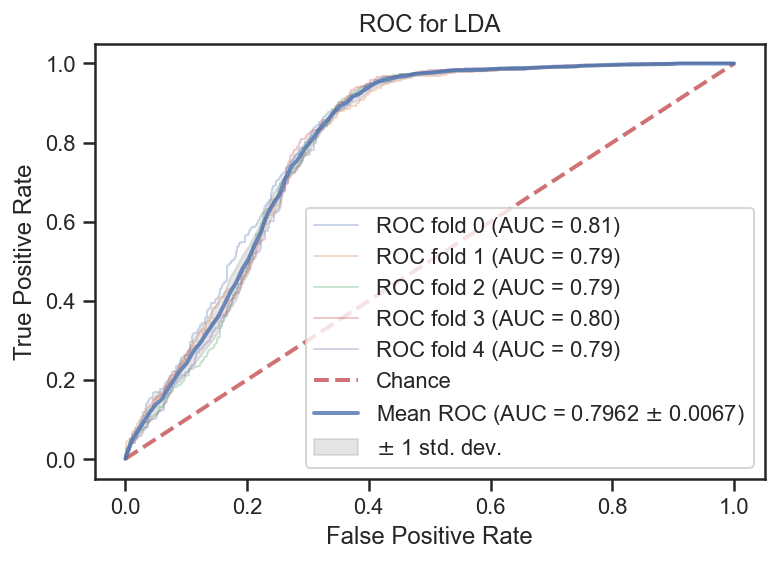

In [5]:
X = df[["qu_dem_MEAN", "qu_floAcu_STD", "qu_curv_MEAN"]]
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_lda, time_lda, cm_lda, cr_lda, acc_lda, roc_lda = LDA(X, y, gridid)
print(f"{time_lda} seconds")
print(f"{acc_lda}")
print(f"{np.mean(acc_lda)} accuracy")
print(cm_lda)
print(cr_lda)
print(roc_lda)

5it [00:00, 21.62it/s]


0.24152550000002293 seconds
[0.8293673824724318, 0.8170731707317073, 0.818815331010453, 0.8315911730545877, 0.8124274099883856]
0.8218548934515132 accuracy
[[1779 1365]
 [ 169 5298]]
              precision    recall  f1-score   support

           0     0.9132    0.5658    0.6987      3144
           1     0.7951    0.9691    0.8735      5467

    accuracy                         0.8219      8611
   macro avg     0.8542    0.7675    0.7861      8611
weighted avg     0.8383    0.8219    0.8097      8611

<module 'matplotlib.pyplot' from 'C:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


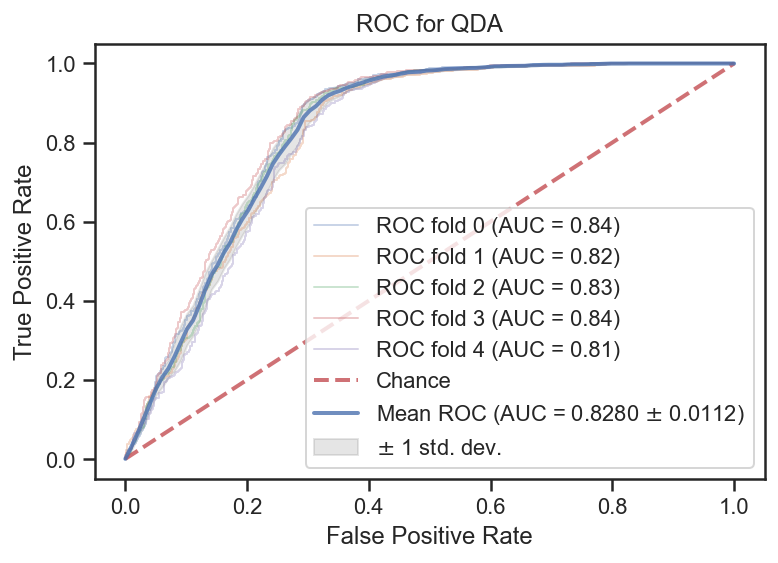

In [6]:
X = df[["qu_dem_MEAN", "qu_floAcu_STD", "qu_curv_MEAN"]]
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_qda, time_qda, cm_qda, cr_qda, acc_qda, roc_qda = QDA(X, y, gridid)
print(f"{time_qda} seconds")
print(f"{acc_qda}")
print(f"{np.mean(acc_qda)} accuracy")
print(cm_qda)
print(cr_qda)
print(roc_qda)

In [9]:
output_df_lda.to_csv("../Comparison Data/LDA.csv")